In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


In [ ]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

In [ ]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None, horizon=96)
df.to_pickle('/tmp/df_horizon96_price_type_none.pkl')
display(df)

In [2]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [6 * 4, 12 * 4, 24 * 4, 36 * 4, 48 * 4, 72 * 4, 96 * 4]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)

        model = clone(self.estimator)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-10-18 01:58:21.697109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 01:58:22.229803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 01:58:22.229830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-18 01:58:22.286397: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 01:58:23.162556: W tensorflow/stream_executor/platform/de

In [5]:
# https://github.com/CyberZHG/keras-drop-connect/blob/master/LICENSE

from inspect import getfullargspec

class GaussianDropConnect(tf.keras.layers.Wrapper):
    def __init__(self, layer, rate=0.0, seed=None, **kwargs):
        super(GaussianDropConnect, self).__init__(layer, **kwargs)
        if isinstance(rate, dict):
            for name in list(rate.keys()):
                rate[name] = min(1., max(0., rate[name]))
        else:
            rate = min(1., max(0., rate))
        self.rate = rate
        self.seed = seed
        self.supports_masking = self.layer.supports_masking

    def build(self, input_shape=None):
        if not self.layer.built:
            self.layer.build(input_shape)
        super(GaussianDropConnect, self).build()
        
        def dropped_weight(weight, drop_connect_rate):
            sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
            def _dropped_weight():
                return weight * tf.keras.backend.random_normal(
                    shape=tf.shape(weight),
                    mean=1.0,
                    stddev=sigma,
                    dtype=weight.dtype,
                    seed=self.seed
                )
                return dropped
            return _dropped_weight

        training = None
        
        weights = []
        for w in self.layer.trainable_weights:
            weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        self.layer.trainable_weights = weights
        
    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def compute_mask(self, inputs, mask=None):
        return self.layer.compute_mask(inputs, mask)

    def call(self, inputs, training=None, mask=None):
        def has_arg(fn, name):
            arg_spec = getfullargspec(fn)
            return name in arg_spec.args or name in arg_spec.kwonlyargs

        kwargs = {}
        if has_arg(self.layer.call, 'training'):
            kwargs['training'] = training
        if has_arg(self.layer.call, 'mask'):
            kwargs['mask'] = mask

#         def dropped_weight(weight, drop_connect_rate):
#             sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
#             def _dropped_weight():
#                 return weight * tf.keras.backend.random_normal(
#                     shape=tf.shape(weight),
#                     mean=1.0,
#                     stddev=sigma,
#                     dtype=weight.dtype,
#                     seed=self.seed
#                 )
#                 return dropped
#             return _dropped_weight

#         origins = self.layer.trainable_weights
        
#         # origins = {}
#         if isinstance(self.rate, dict):
#             for name, rate in self.rate.items():
#                 w = getattr(self.layer, name)
#                 if w in self.layer.trainable_weights:
#                     origins[name] = w
#                     if 0. < rate < 1.:
#                         setattr(self.layer, name, )
#         else:
#             weights = []
#             for w in self.layer.trainable_weights:
#                 weights.append(tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
#             self.layer.set_weights(weights)
                    
# #             for name in dir(self.layer):
# #                 try:
# #                     w = getattr(self.layer, name)
# #                 except Exception as e:
# #                     continue
                
# #                 if w in self.layer.trainable_weights:
# #                     origins[name] = w
# #                     if 0. < self.rate < 1.:
# #                         setattr(self.layer, name, tf.keras.backend.in_train_phase(dropped_weight(w, self.rate), w, training=training))
        outputs = self.layer.call(inputs, **kwargs)
        # for name, w in origins.items():
        #     setattr(self.layer, name, w)
        # self.layer.set_weights(origins)
        return outputs

    def get_config(self):
        config = {
            'rate': self.rate,
            'seed': self.seed,
        }
        base_config = super(GaussianDropConnect, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [7]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [8]:
class WeightShuffleCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch > 20:
            return
        
        weights = self.model.get_weights()
        for i in range(0, len(weights)):
        # for i in range(len(weights) // 2, len(weights)):
            w = weights[i]
            if False:
            # if len(w.shape) == 1:
                w[:] = 0.0
            else:
                # flatten shuffle
                w = np.random.permutation(w.flatten()).reshape(w.shape)
                # axis 0 shuffle
                # w = np.random.permutation(w)
                # axis 1 shuffle 
                # maybe overfit
                # if len(w.shape) == 2:
                #     w = np.random.permutation(w.T).T
                # else:
                #     w = np.random.permutation(w)
            weights[i] = w

        self.model.set_weights(weights)


In [9]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [10]:
# https://arxiv.org/pdf/2002.08253.pdf
class MarsConstraint(tf.keras.constraints.Constraint):
    def __init__(self, gamma):
        self.gamma = gamma
        self.initial_weight = None

    def __call__(self, w):
        w = w - self.initial_weight
        norms = tf.keras.backend.sum(tf.keras.backend.abs(w), axis=range(len(w.shape) - 1), keepdims=True)
        w *= (1.0 / tf.keras.backend.maximum(1.0, norms / self.gamma))
        w += self.initial_weight
        return w

    def get_config(self):
        return { "gamma": self.gamma }

In [11]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [12]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [15]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            patience=10,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    # tb, # last
                ],
                batch_size=4096 * 8,
                # batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('remove_nonstationary1', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('remove_nonstationary2', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    # act = 'elu'
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    
    def initializer(shape, dtype=None):
        p = 0.1
        dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
        # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
        # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
        w = initializers.HeNormal()(shape, dtype=dtype)
        # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
        # w = w ** 3 # 3 is good
        w /= tf.reduce_mean(w ** 2) ** 0.5
        print(shape)
        n_in, n_out = shape
        # w /= n_in ** 0.5
        # w /= n_out ** 0.5 # good
        
        # https://arxiv.org/pdf/1902.06853.pdf
        w /= n_in ** 0.5
        # w *= 1.3
        # w *= 0.9
        return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    # not bad
#     x = Dense(size ** 4, use_bias=True, 
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size, size, size))(x)
    
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv3D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    
    # good
#     reg_cnn = reg
#     # reg_cnn = regularizers.l2(1e-3 * size ** 2)
#     reg_cnn1 = DistanceL2(l2_dist)
#     cnn1 = Dense(size ** 3,
#              # activation='relu',
#              use_bias=True,
#              # use_bias=False, # bad ?
#              kernel_regularizer=reg, 
#              # kernel_regularizer=reg_cnn1,
#              # kernel_regularizer=reg_l1, 
#              bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#     )
#     x = cnn1(x)
#     # x = Dropout(0.9)(x)
#     x = Reshape((size, size, size))(x)
    
#     reg_cnn2 = DistanceL2(l2_dist)
#     cnn2 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn, 
#                # kernel_regularizer=reg_cnn2, 
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn2(x)
#     # x = Dropout(0.9)(x)
#     reg_cnn3 = DistanceL2(l2_dist)
#     cnn3 = Conv2D(filters=size, kernel_size=kernel_size, activation=act, use_bias=True, padding='SAME',
#                kernel_regularizer=reg_cnn,
#                # kernel_regularizer=reg_cnn3,
#                bias_regularizer=reg_cnn,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )
#     x = cnn3(x)
    # x = Dropout(0.9)(x)
    
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    # x = Flatten()(x)
    # x = Dense(size ** 3, 
    #          # activation='relu',
    #          use_bias=True,
    #          # use_bias=False, # bad ?
    #          kernel_regularizer=reg, bias_regularizer=reg,
    #          kernel_initializer=initializer, # bias_initializer=initializer,
    #          )(x)
    # x = Reshape((size, size, size))(x)
    # x = Conv2D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.9)(x)
    
#     x = Dense(size ** 2, use_bias=True,
#              kernel_regularizer=reg, bias_regularizer=reg,
#              kernel_initializer=initializer, # bias_initializer=initializer,
#              )(x)
#     x = Reshape((size, size))(x)
    
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
#     x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
#                kernel_regularizer=reg, bias_regularizer=reg,
#                kernel_initializer=initializer, # bias_initializer=initializer,
#               )(x)
#     x = Dropout(0.9)(x)
    # x = Conv1D(filters=size, kernel_size=kernel_size, activation='relu', use_bias=True, padding='SAME',
    #            kernel_regularizer=reg, bias_regularizer=reg,
    #            kernel_initializer=initializer, # bias_initializer=initializer,
    #           )(x)
    # x = Dropout(0.5)(x)
    
    # x = MaxPooling1D(pool_size=4, strides=2)(x)
    # x = AveragePooling1D(pool_size=4, strides=2)(x)
    # x = Flatten()(x)
    
    # x = tf.keras.layers.GaussianNoise(0.5)(x)
    
    # size = 32
    size = 64
    # size = 128
    # size = 512
    # size = 1024
    reg1 = DistanceL2(l2_dist)
    # d1 = tfa.layers.NoisyDense(
    # d1 = Dense(
    #     256,
    #     # size,
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg1,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d1(x)
    # x = BatchNormalization()(x)
    # x = Concatenate()([x, inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    reg2 = DistanceL2(l2_dist)
    d2_inputs = x
    # d2 = tfa.layers.NoisyDense(
    # d2 = Dense(
    #     # 64, 
    #     128,
    #     # 512,
    #     # size, 
    #     activation=act, 
    #     # use_factorised=False,
    #     use_bias=True,
    #     # use_bias=False, 
    #     # kernel_regularizer=reg_l1, 
    #     kernel_regularizer=reg,
    #     # kernel_regularizer=reg2,
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, # bias_initializer=initializer,
    #     # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
    # )
    # x = d2(x)
    # x = Concatenate()([x, inputs, d2_inputs])
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    depth = 2 + idx * 0
    for i in range(depth):
        t = 1.0 * i / (depth - 1)
        x_prev = x
        
        dist_reg = DistanceL2(l2_dist)
        dist_regs.append(dist_reg)
        mars_constraint = MarsConstraint(8)
        mars_constraints.append(mars_constraint)
        # dense = GaussianDropConnectDense(
        dense = Dense(
            # size,
            # 32,
            # 64,
            128, # good with l2 reg
            # 256,
            # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
            # 64 if i == 0 else 128,
            activation=act, 
            # activation=None,
            use_bias=True,
            # use_bias=False,
            # kernel_regularizer=reg_l1, 
            kernel_regularizer=reg,
            # kernel_regularizer=dist_reg,
            # kernel_regularizer=reg2,
            bias_regularizer=reg,
            # kernel_initializer='zeros' if i > 0 else initializer,
            kernel_initializer=initializer, 
            bias_initializer=bias_initializer,
            # kernel_constraint=mars_constraint,
            # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
        )
        dist_reg_layers.append(dense)
        # dense = GaussianDropConnect(dense, rate=0.2)
        x = dense(x)
        # x = BatchNormalization()(x)
        # def smooth_units(x):
        #     return (x[:, 1:] + x[:, :-1]) / 2
        #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
        # x = Lambda(smooth_units)(x)
        # x = Activation(act)(x)
        # x = Lambda(smooth_units)(x)
        # if i > 0:
        #     x = Add()([x, x_prev])
        # if i == 9:
        #     x = tf.keras.layers.GaussianDropout(0.5)(x)
        # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
        # x = Dropout(dropout_rate)(x)
        # x = Dropout(0.1)(x)
        # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
        hidden_outputs.append(x)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
        # dense = GaussianDropConnectDense(
        # dense1 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense1)
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         # dense = GaussianDropConnectDense(
#         dense2 = Dense(
#             # size,
#             int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             activation=None, use_bias=True,
#             # kernel_regularizer=reg_l1, 
#             # kernel_regularizer=reg,
#             kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             # bias_initializer=initializer,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense2)
        
#         u = dense1(x)
#         v = dense2(x)
#         x = Concatenate()([Add()([u, v]), Subtract()([u, v])])
#         x = Rescaling(0.5 ** 0.5)(x)
#         x = Activation(act)(x)
        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1, 
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    # opt = Nadam(
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.002,
    #     beta_1=0.9, 
    #     # beta_1=0.5,
    #     # beta_2=0.9,
    #     beta_2=0.999,
    #     epsilon=None,
    #     # epsilon=1e-1,
    #     # epsilon=1e-3,
    #     schedule_decay=0.004,
    # )
    opt = tfa.optimizers.AdaBelief(
        # learning_rate=0.001,
        learning_rate=0.001 / 8,
        # learning_rate=0.001 / 8 / 8,
        # learning_rate=0.001 / 8 / 8 / 8,
        # total_steps=1200,
        # warmup_proportion=0.1,
        # min_lr=1e-5,
        # rectify=True,
        # weight_decay=1e-2,
        # weight_decay=1e-3,
        # epsilon=1e-10,
    )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # 0.18 1.3 drop connect sigma 0.5 2e-4
    # 0.15 1.1 drop connect sigma 0.5 2e-4 es 40
    # 0.17 1.2 2e-4
    # todo 1e-4
    # 0.164 1.0 drop connect sigma 0.5 2e-3 
    # 0.135 1.0 2e-3
    # 0.17 1.1 2e-3 dist l2 1e-4
    # 0.170 1.35 2e-3 dist l2 0 elu
    # 0.182 1.44 2e-3 dist l2 0 elu mixout(weight)
    # 0.182 1.37 2e-4 dist l2 0 elu mixout(weight)
    # 0.191 1.52 2e-4(patient40) dist l2 0 elu mixout(weight) https://gist.github.com/richmanbtc/e3b7b480466e425ee12223e476b2643e
    # 0.165 1.14 adabelief dist l2 0 elu last layer zeros no output rescaling
    # 0.159 1.14 adabelief dist l2 0 elu last layer zeros
    # 0.182 1.24 adabelief dist l2 0 elu batch 512 lr 0.001 / 8
    # 0.173 1.32 adabelief dist l2 0 elu batch 64 lr 0.001 / 64
    # 0.172 1.47 adabelief dist l2 0 elu smooth
    # 0.169 1.41 adabelief dist l2 0 elu smooth unit 128
    # 0.161 1.24 adabelief dist l2 0 elu smooth unit 128 last pooling 2
    # 0.164 1.25 adabelief dist l2 0 elu smooth 4
    # 0.183 1.47 adabelief dist l2 0 elu mixout(weight, 0.5)
    # 0.180 1.36 adabelief dist l2 0 elu mixout(weight, 0.7)
    # 0.180 1.35 adabelief dist l2 0 elu mixout(weight, 0.3)
    # 0.176 1.46 adabelief dist l2 0 elu
    # 0.180 1.60 adabelief dist l2 0 elu output gaussian dropout 0.5 work1:https://gist.github.com/richmanbtc/da475809b4da464de864f661db7ab033
    # 0.183 1.61 adabelief dist l2 0 elu output dropout 0.5
    # 0.191 1.55 adabelief dist l2 0 elu output dropout 0.5 mixout(weight, 0.5)
    # 0.168 1.11 adabelief dist l2 0 elu no dropout
    # 0.159 1.28 adabelief dist l2 0 elu no dropout output l2 0.01
    # 0.187 1.57 2e-4 dist l2 0 elu output dropout 0.5
    # 0.178 1.40 adabelief dist l2 1e-4 elu
    # 0.163 1.27 adabelief dist l2 0 elu dropout 0.995 unit 128
    # 0.177 1.40 adabelief dist l2 0 elu unit 128 mixout(weight, 0.5)
    # 0.193 1.52 adabelief dist l2 0 elu mars 8 https://gist.github.com/richmanbtc/1a86fa1e40c5afad8de129373cabe372
    # 0.163 1.19 adabelief dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.185 1.47 2e-4 dist l2 0 elu mars 8
    # 0.185 1.37 2e-4 dist l2 0 elu mars 8 mixout(weight, 0.5)
    # 0.180 1.38 2e-3 dist l2 0 elu gaussian mixout(weight)
    # 0.156 1.18 2e-3 dist l2 0 elu 6 layer
    # 0.150 1.09 2e-3 dist l2 0 relu 6 layer
    # 0.154 1.22 2e-3 dist l2 1e-4 relu 6 layer
    # 0.155 1.18 2e-3 dist l2 1e-4 elu 6 layer
    # 0.165 1.20 2e-3 dist l2 0 elu mixout(weight) 6 layer
    # 0.155 1.32 2e-3 dist l2 0 elu gaussian mixout(weight) 6 layer
    # 0.168 1.34 2e-3 dist l2 0 elu mixout(weight) 4 layer
    # 0.170 1.32 2e-3 dist l2 1e-4 elu
    # 0.175 1.31 2e-3 dist l2 1e-4 elu mixout(weight)
    # 0.185 1.37 2e-4 dist l2 1e-4 relu
    # 0.187 1.48 2e-4 dist l2 1e-4 elu https://gist.github.com/richmanbtc/0d4f571b5bc21b590934e4930b54a21e
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     # learning_rate=0.002,
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

float32
fit df.shape (195540, 730)


2022-10-18 02:34:58.202150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-18 02:34:58.202199: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-18 02:34:58.202225: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (540c7ea3ab0a): /proc/driver/nvidia/version does not exist
2022-10-18 02:34:58.202446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
5/5 - 4s - loss: 1.1279 - mse: 1.0001 - weighted_mse: 0.9986 - cosine_similarity: 0.0642 - val_loss: 0.6980 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -2.0113e-03 - 4s/epoch - 736ms/step
Epoch 2/1000
5/5 - 1s - loss: 1.1279 - mse: 1.0001 - weighted_mse: 0.9986 - cosine_similarity: 0.0654 - val_loss: 0.6980 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -5.1791e-03 - 1s/epoch - 229ms/step
Epoch 3/1000
5/5 - 1s - loss: 1.1276 - mse: 1.0001 - weighted_mse: 0.9984 - cosine_similarity: 0.0720 - val_loss: 0.6979 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -1.8439e-03 - 881ms/epoch - 176ms/step
Epoch 4/1000
5/5 - 1s - loss: 1.1273 - mse: 1.0001 - weighted_mse: 0.9980 - cosine_similarity: 0.0822 - val_loss: 0.6979 - val_mse: 1.0005 - val_weighted_mse: 1.0001 - val_cosine_similarity: 0.0011 - 899ms/epoch - 180ms/step
Epoch 5/1000
5/5 - 1s - loss: 1.1268 - mse: 1.0001 - weighte

2022-10-18 02:56:17.369633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:17.369698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:17.373370: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfbe8hdts
2022-10-18 02:56:17.379546: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:17.379596: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfbe8hdts
2022-10-18 02:56:17.387076: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-10-18 02:56:17.389192: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:17.443420: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfbe8hdts
2022-10

INFO:tensorflow:Assets written to: /tmp/tmpcvqjvsmq/assets


INFO:tensorflow:Assets written to: /tmp/tmpcvqjvsmq/assets
2022-10-18 02:56:19.222820: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:19.222881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:19.223021: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcvqjvsmq
2022-10-18 02:56:19.224345: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:19.224365: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcvqjvsmq
2022-10-18 02:56:19.228849: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:19.275797: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcvqjvsmq
2022-10-18 02:56:19.284571: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps9qbq5pf/assets


INFO:tensorflow:Assets written to: /tmp/tmps9qbq5pf/assets
2022-10-18 02:56:20.408846: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:20.408909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:20.409091: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps9qbq5pf
2022-10-18 02:56:20.410613: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:20.410641: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps9qbq5pf
2022-10-18 02:56:20.415291: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:20.459641: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps9qbq5pf
2022-10-18 02:56:20.468783: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8pj7nutu/assets


INFO:tensorflow:Assets written to: /tmp/tmp8pj7nutu/assets
2022-10-18 02:56:21.573664: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:21.573711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:21.573832: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8pj7nutu
2022-10-18 02:56:21.575188: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:21.575208: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8pj7nutu
2022-10-18 02:56:21.580191: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:21.625016: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8pj7nutu
2022-10-18 02:56:21.633489: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz0c6lrl3/assets


INFO:tensorflow:Assets written to: /tmp/tmpz0c6lrl3/assets
2022-10-18 02:56:22.723826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:22.723888: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:22.724037: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz0c6lrl3
2022-10-18 02:56:22.725434: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:22.725458: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz0c6lrl3
2022-10-18 02:56:22.729740: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:22.776618: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz0c6lrl3
2022-10-18 02:56:22.786975: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0xccs0gs/assets


INFO:tensorflow:Assets written to: /tmp/tmp0xccs0gs/assets
2022-10-18 02:56:23.845278: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:23.845363: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:23.845651: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0xccs0gs
2022-10-18 02:56:23.846827: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:23.846844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0xccs0gs
2022-10-18 02:56:23.851598: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:23.898252: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0xccs0gs
2022-10-18 02:56:23.908265: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo5i2zdq3/assets


INFO:tensorflow:Assets written to: /tmp/tmpo5i2zdq3/assets
2022-10-18 02:56:24.967758: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:24.967816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:24.967956: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo5i2zdq3
2022-10-18 02:56:24.969350: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:24.969373: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo5i2zdq3
2022-10-18 02:56:24.974673: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:25.018036: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo5i2zdq3
2022-10-18 02:56:25.026609: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp2ic3rgk/assets


INFO:tensorflow:Assets written to: /tmp/tmpp2ic3rgk/assets
2022-10-18 02:56:26.084435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:26.084481: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:26.084595: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp2ic3rgk
2022-10-18 02:56:26.085787: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:26.085806: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp2ic3rgk
2022-10-18 02:56:26.090594: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:26.132008: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp2ic3rgk
2022-10-18 02:56:26.140595: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9_svixc1/assets


INFO:tensorflow:Assets written to: /tmp/tmp9_svixc1/assets
2022-10-18 02:56:29.101807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:29.101856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:29.102059: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9_svixc1
2022-10-18 02:56:29.103267: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:29.103285: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9_svixc1
2022-10-18 02:56:29.107336: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:29.149223: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9_svixc1
2022-10-18 02:56:29.159490: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_23wso00/assets


INFO:tensorflow:Assets written to: /tmp/tmp_23wso00/assets
2022-10-18 02:56:30.181094: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 02:56:30.181159: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 02:56:30.181275: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_23wso00
2022-10-18 02:56:30.182406: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 02:56:30.182425: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_23wso00
2022-10-18 02:56:30.186476: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 02:56:30.228606: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_23wso00
2022-10-18 02:56:30.238932: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

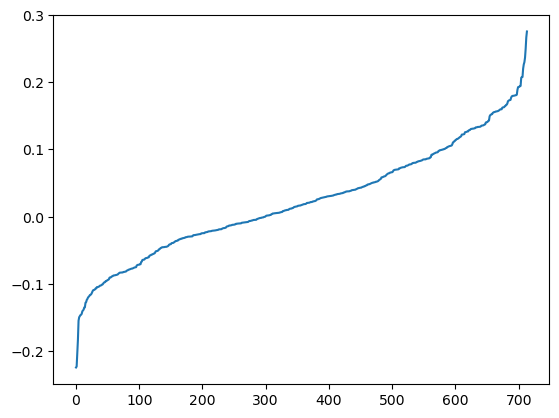

fit df.shape (181853, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 3s - loss: 1.1303 - mse: 1.0001 - weighted_mse: 0.9990 - cosine_similarity: 0.0528 - val_loss: 0.6933 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -4.1517e-03 - 3s/epoch - 628ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.1303 - mse: 1.0001 - weighted_mse: 0.9990 - cosine_similarity: 0.0533 - val_loss: 0.6933 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -4.1773e-03 - 849ms/epoch - 212ms/step
Epoch 3/1000
4/4 - 1s - loss: 1.1302 - mse: 1.0002 - weighted_mse: 0.9989 - cosine_similarity: 0.0600 - val_loss: 0.6933 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -3.7287e-03 - 833ms/epoch - 208ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.1300 - mse: 1.0002 - weighted_mse: 0.9987 - cosine_similarity: 0.0674 - val_loss: 0.6933 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -3.4272e-03 - 1s/epoch - 286ms/step
Epoch 5/1000
4/4 - 1s - loss

INFO:tensorflow:Assets written to: /tmp/tmpq8teas45/assets
2022-10-18 03:17:05.925394: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:05.925443: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:05.925559: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq8teas45
2022-10-18 03:17:05.926652: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:05.926670: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq8teas45
2022-10-18 03:17:05.931846: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:05.974832: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq8teas45
2022-10-18 03:17:05.983727: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoh2ln313/assets


INFO:tensorflow:Assets written to: /tmp/tmpoh2ln313/assets
2022-10-18 03:17:08.157098: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:08.157209: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:08.157345: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoh2ln313
2022-10-18 03:17:08.158614: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:08.158633: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoh2ln313
2022-10-18 03:17:08.162976: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:08.208357: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoh2ln313
2022-10-18 03:17:08.219447: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbeo9vg7_/assets


INFO:tensorflow:Assets written to: /tmp/tmpbeo9vg7_/assets
2022-10-18 03:17:09.187771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:09.187818: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:09.188031: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbeo9vg7_
2022-10-18 03:17:09.189469: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:09.189488: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbeo9vg7_
2022-10-18 03:17:09.193225: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:09.236158: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbeo9vg7_
2022-10-18 03:17:09.245117: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp567kcqp8/assets


INFO:tensorflow:Assets written to: /tmp/tmp567kcqp8/assets
2022-10-18 03:17:10.236634: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:10.236681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:10.236828: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp567kcqp8
2022-10-18 03:17:10.237865: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:10.237882: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp567kcqp8
2022-10-18 03:17:10.241629: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:10.285511: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp567kcqp8
2022-10-18 03:17:10.295954: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpllb4wjdp/assets


INFO:tensorflow:Assets written to: /tmp/tmpllb4wjdp/assets
2022-10-18 03:17:11.305479: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:11.305529: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:11.305658: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpllb4wjdp
2022-10-18 03:17:11.306823: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:11.306842: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpllb4wjdp
2022-10-18 03:17:11.311028: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:11.357679: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpllb4wjdp
2022-10-18 03:17:11.366947: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp48hj8rye/assets


INFO:tensorflow:Assets written to: /tmp/tmp48hj8rye/assets
2022-10-18 03:17:12.318074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:12.318122: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:12.318243: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp48hj8rye
2022-10-18 03:17:12.319400: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:12.319418: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp48hj8rye
2022-10-18 03:17:12.323084: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:12.362675: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp48hj8rye
2022-10-18 03:17:12.371342: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyke6updr/assets


INFO:tensorflow:Assets written to: /tmp/tmpyke6updr/assets
2022-10-18 03:17:13.339955: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:13.340042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:13.340163: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyke6updr
2022-10-18 03:17:13.341273: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:13.341291: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyke6updr
2022-10-18 03:17:13.345007: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:13.386615: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyke6updr
2022-10-18 03:17:13.395511: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp35imgzkt/assets


INFO:tensorflow:Assets written to: /tmp/tmp35imgzkt/assets
2022-10-18 03:17:14.343361: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:14.343408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:14.343526: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp35imgzkt
2022-10-18 03:17:14.344625: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:14.344643: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp35imgzkt
2022-10-18 03:17:14.348245: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:14.388366: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp35imgzkt
2022-10-18 03:17:14.397434: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpos__advm/assets


INFO:tensorflow:Assets written to: /tmp/tmpos__advm/assets
2022-10-18 03:17:15.362991: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:15.363037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:15.363155: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpos__advm
2022-10-18 03:17:15.364271: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:15.364289: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpos__advm
2022-10-18 03:17:15.368122: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:15.407459: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpos__advm
2022-10-18 03:17:15.416143: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp13x4x6_2/assets


INFO:tensorflow:Assets written to: /tmp/tmp13x4x6_2/assets
2022-10-18 03:17:16.387298: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:17:16.387345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:17:16.387467: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp13x4x6_2
2022-10-18 03:17:16.388634: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:17:16.388652: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp13x4x6_2
2022-10-18 03:17:16.392368: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:17:16.433798: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp13x4x6_2
2022-10-18 03:17:16.442835: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

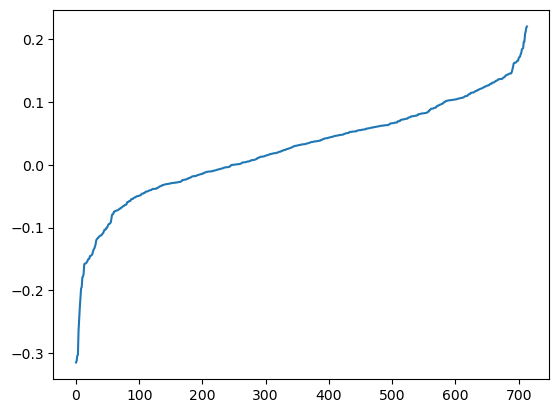

fit df.shape (174593, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 2s - loss: 1.0663 - mse: 1.0002 - weighted_mse: 0.9991 - cosine_similarity: 0.0558 - val_loss: 0.8433 - val_mse: 1.0003 - val_weighted_mse: 1.0001 - val_cosine_similarity: -2.0844e-03 - 2s/epoch - 605ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.0662 - mse: 1.0002 - weighted_mse: 0.9991 - cosine_similarity: 0.0562 - val_loss: 0.8433 - val_mse: 1.0003 - val_weighted_mse: 1.0001 - val_cosine_similarity: -1.4989e-03 - 795ms/epoch - 199ms/step
Epoch 3/1000
4/4 - 1s - loss: 1.0661 - mse: 1.0002 - weighted_mse: 0.9990 - cosine_similarity: 0.0618 - val_loss: 0.8433 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -1.8722e-03 - 761ms/epoch - 190ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.0659 - mse: 1.0002 - weighted_mse: 0.9988 - cosine_similarity: 0.0708 - val_loss: 0.8433 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: -4.0672e-03 - 770ms/epoch - 192ms/step
Epoch 5/1000
4/4 - 1s - l

INFO:tensorflow:Assets written to: /tmp/tmpoc77lyyn/assets
2022-10-18 03:34:22.860984: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:22.861042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:22.861179: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoc77lyyn
2022-10-18 03:34:22.862560: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:22.862583: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoc77lyyn
2022-10-18 03:34:22.866843: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:22.916849: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoc77lyyn
2022-10-18 03:34:22.927291: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpj3o58n44/assets


INFO:tensorflow:Assets written to: /tmp/tmpj3o58n44/assets
2022-10-18 03:34:25.239049: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:25.239104: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:25.239249: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpj3o58n44
2022-10-18 03:34:25.240820: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:25.240844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpj3o58n44
2022-10-18 03:34:25.245824: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:25.293800: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpj3o58n44
2022-10-18 03:34:25.305088: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3za5j0pu/assets


INFO:tensorflow:Assets written to: /tmp/tmp3za5j0pu/assets
2022-10-18 03:34:26.435205: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:26.435288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:26.435438: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3za5j0pu
2022-10-18 03:34:26.436820: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:26.436843: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3za5j0pu
2022-10-18 03:34:26.441099: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:26.486328: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3za5j0pu
2022-10-18 03:34:26.496180: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmce31bvr/assets


INFO:tensorflow:Assets written to: /tmp/tmpmce31bvr/assets
2022-10-18 03:34:27.597279: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:27.597364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:27.597502: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmce31bvr
2022-10-18 03:34:27.598818: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:27.598839: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmce31bvr
2022-10-18 03:34:27.603090: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:27.648954: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmce31bvr
2022-10-18 03:34:27.658952: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsim74u2k/assets


INFO:tensorflow:Assets written to: /tmp/tmpsim74u2k/assets
2022-10-18 03:34:28.756690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:28.756744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:28.756881: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsim74u2k
2022-10-18 03:34:28.758244: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:28.758267: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsim74u2k
2022-10-18 03:34:28.762552: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:28.811240: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsim74u2k
2022-10-18 03:34:28.821444: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3l2ir8s2/assets


INFO:tensorflow:Assets written to: /tmp/tmp3l2ir8s2/assets
2022-10-18 03:34:29.914356: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:29.914441: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:29.914586: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3l2ir8s2
2022-10-18 03:34:29.915910: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:29.915932: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3l2ir8s2
2022-10-18 03:34:29.920209: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:29.964906: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3l2ir8s2
2022-10-18 03:34:29.974855: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbmzunj_q/assets


INFO:tensorflow:Assets written to: /tmp/tmpbmzunj_q/assets
2022-10-18 03:34:31.036571: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:31.036697: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:31.036914: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbmzunj_q
2022-10-18 03:34:31.038023: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:31.038041: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbmzunj_q
2022-10-18 03:34:31.041559: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:31.087007: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbmzunj_q
2022-10-18 03:34:31.098128: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph1533w_d/assets


INFO:tensorflow:Assets written to: /tmp/tmph1533w_d/assets
2022-10-18 03:34:32.071427: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:32.071497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:32.071638: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph1533w_d
2022-10-18 03:34:32.072807: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:32.072825: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph1533w_d
2022-10-18 03:34:32.076623: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:32.128777: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph1533w_d
2022-10-18 03:34:32.138221: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp__390389/assets


INFO:tensorflow:Assets written to: /tmp/tmp__390389/assets
2022-10-18 03:34:33.109394: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:33.109447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:33.109585: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp__390389
2022-10-18 03:34:33.110899: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:33.110919: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp__390389
2022-10-18 03:34:33.115255: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:33.156691: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp__390389
2022-10-18 03:34:33.164974: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv8hpx0d3/assets


INFO:tensorflow:Assets written to: /tmp/tmpv8hpx0d3/assets
2022-10-18 03:34:34.121013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:34:34.121091: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:34:34.121413: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv8hpx0d3
2022-10-18 03:34:34.123605: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:34:34.123635: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv8hpx0d3
2022-10-18 03:34:34.132159: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:34:34.173771: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv8hpx0d3
2022-10-18 03:34:34.182355: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

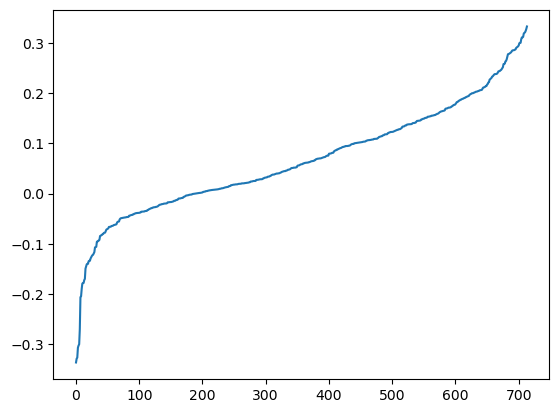

fit df.shape (174593, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 3s - loss: 1.1255 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0579 - val_loss: 0.7040 - val_mse: 1.0003 - val_weighted_mse: 1.0001 - val_cosine_similarity: 0.0075 - 3s/epoch - 725ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.1255 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0590 - val_loss: 0.7040 - val_mse: 1.0004 - val_weighted_mse: 1.0001 - val_cosine_similarity: 0.0068 - 924ms/epoch - 231ms/step
Epoch 3/1000
4/4 - 2s - loss: 1.1253 - mse: 1.0001 - weighted_mse: 0.9986 - cosine_similarity: 0.0652 - val_loss: 0.7040 - val_mse: 1.0004 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0049 - 2s/epoch - 442ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.1251 - mse: 1.0001 - weighted_mse: 0.9984 - cosine_similarity: 0.0738 - val_loss: 0.7040 - val_mse: 1.0004 - val_weighted_mse: 1.0000 - val_cosine_similarity: 0.0067 - 784ms/epoch - 196ms/step
Epoch 5/1000
4/4 - 1s - loss: 1.1247 - mse: 1.00

INFO:tensorflow:Assets written to: /tmp/tmp6tq948ue/assets
2022-10-18 03:55:20.169246: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:20.169331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:20.169601: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6tq948ue
2022-10-18 03:55:20.171565: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:20.171596: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6tq948ue
2022-10-18 03:55:20.177720: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:20.246046: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6tq948ue
2022-10-18 03:55:20.259138: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9hq58fxq/assets


INFO:tensorflow:Assets written to: /tmp/tmp9hq58fxq/assets
2022-10-18 03:55:21.843411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:21.843511: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:21.843841: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9hq58fxq
2022-10-18 03:55:21.845559: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:21.845592: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9hq58fxq
2022-10-18 03:55:21.851485: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:21.919190: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9hq58fxq
2022-10-18 03:55:21.933733: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq8vsx27l/assets


INFO:tensorflow:Assets written to: /tmp/tmpq8vsx27l/assets
2022-10-18 03:55:23.389152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:23.389234: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:23.389412: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq8vsx27l
2022-10-18 03:55:23.391051: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:23.391082: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq8vsx27l
2022-10-18 03:55:23.397297: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:23.457775: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq8vsx27l
2022-10-18 03:55:23.469919: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd9gfookq/assets


INFO:tensorflow:Assets written to: /tmp/tmpd9gfookq/assets
2022-10-18 03:55:24.972666: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:24.972747: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:24.972956: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd9gfookq
2022-10-18 03:55:24.974646: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:24.974695: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd9gfookq
2022-10-18 03:55:24.982190: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:25.043505: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd9gfookq
2022-10-18 03:55:25.056191: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4_ytg393/assets


INFO:tensorflow:Assets written to: /tmp/tmp4_ytg393/assets
2022-10-18 03:55:26.470599: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:26.470664: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:26.470863: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4_ytg393
2022-10-18 03:55:26.472384: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:26.472408: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4_ytg393
2022-10-18 03:55:26.477336: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:26.531054: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4_ytg393
2022-10-18 03:55:26.543343: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3qtil_1k/assets


INFO:tensorflow:Assets written to: /tmp/tmp3qtil_1k/assets
2022-10-18 03:55:27.874032: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:27.874100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:27.874259: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3qtil_1k
2022-10-18 03:55:27.875786: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:27.875861: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3qtil_1k
2022-10-18 03:55:27.882512: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:27.940552: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3qtil_1k
2022-10-18 03:55:27.952212: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxrp2c4f7/assets


INFO:tensorflow:Assets written to: /tmp/tmpxrp2c4f7/assets
2022-10-18 03:55:29.211407: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:29.211472: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:29.211716: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxrp2c4f7
2022-10-18 03:55:29.213440: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:29.213467: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxrp2c4f7
2022-10-18 03:55:29.219312: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:29.274340: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxrp2c4f7
2022-10-18 03:55:29.286381: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_m86q0ni/assets


INFO:tensorflow:Assets written to: /tmp/tmp_m86q0ni/assets
2022-10-18 03:55:30.530337: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:30.530398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:30.530548: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_m86q0ni
2022-10-18 03:55:30.531994: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:30.532019: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_m86q0ni
2022-10-18 03:55:30.536564: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:30.602339: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_m86q0ni
2022-10-18 03:55:30.613340: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5qlxll61/assets


INFO:tensorflow:Assets written to: /tmp/tmp5qlxll61/assets
2022-10-18 03:55:33.935054: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:33.935112: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:33.935253: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5qlxll61
2022-10-18 03:55:33.936800: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:33.936823: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5qlxll61
2022-10-18 03:55:33.942002: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:33.992208: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5qlxll61
2022-10-18 03:55:34.003643: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjitmr2ie/assets


INFO:tensorflow:Assets written to: /tmp/tmpjitmr2ie/assets
2022-10-18 03:55:35.143476: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 03:55:35.143536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 03:55:35.143674: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjitmr2ie
2022-10-18 03:55:35.145073: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 03:55:35.145095: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjitmr2ie
2022-10-18 03:55:35.149856: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 03:55:35.198639: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjitmr2ie
2022-10-18 03:55:35.209240: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

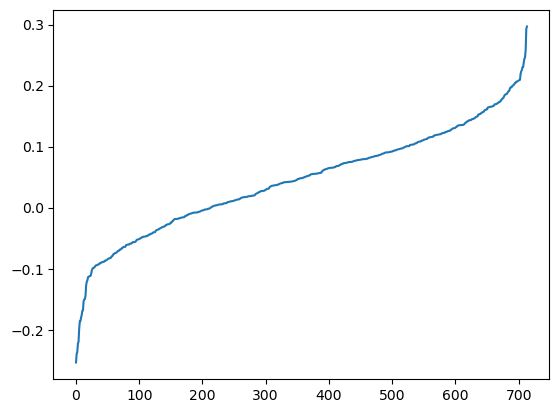

fit df.shape (175043, 730)
[714, 128]
[128, 128]
[128, 1]
Epoch 1/1000
4/4 - 3s - loss: 1.0535 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0614 - val_loss: 0.8719 - val_mse: 1.0002 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0419 - 3s/epoch - 771ms/step
Epoch 2/1000
4/4 - 1s - loss: 1.0535 - mse: 1.0001 - weighted_mse: 0.9988 - cosine_similarity: 0.0623 - val_loss: 0.8718 - val_mse: 1.0002 - val_weighted_mse: 0.9997 - val_cosine_similarity: 0.0437 - 1s/epoch - 333ms/step
Epoch 3/1000
4/4 - 2s - loss: 1.0534 - mse: 1.0001 - weighted_mse: 0.9986 - cosine_similarity: 0.0676 - val_loss: 0.8718 - val_mse: 1.0002 - val_weighted_mse: 0.9996 - val_cosine_similarity: 0.0493 - 2s/epoch - 513ms/step
Epoch 4/1000
4/4 - 1s - loss: 1.0531 - mse: 1.0001 - weighted_mse: 0.9984 - cosine_similarity: 0.0743 - val_loss: 0.8717 - val_mse: 1.0002 - val_weighted_mse: 0.9995 - val_cosine_similarity: 0.0565 - 824ms/epoch - 206ms/step
Epoch 5/1000
4/4 - 1s - loss: 1.0528 - mse: 1.0001 

INFO:tensorflow:Assets written to: /tmp/tmp_h7pckpu/assets
2022-10-18 04:23:07.829827: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:07.829893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:07.830075: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_h7pckpu
2022-10-18 04:23:07.831808: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:07.831835: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_h7pckpu
2022-10-18 04:23:07.838677: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:07.916773: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_h7pckpu
2022-10-18 04:23:07.930973: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6svgilsu/assets


INFO:tensorflow:Assets written to: /tmp/tmp6svgilsu/assets
2022-10-18 04:23:09.360695: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:09.360762: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:09.360924: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6svgilsu
2022-10-18 04:23:09.363172: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:09.363203: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6svgilsu
2022-10-18 04:23:09.370365: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:09.428768: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6svgilsu
2022-10-18 04:23:09.441087: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfgf35xf6/assets


INFO:tensorflow:Assets written to: /tmp/tmpfgf35xf6/assets
2022-10-18 04:23:10.803847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:10.803913: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:10.804077: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfgf35xf6
2022-10-18 04:23:10.805717: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:10.805743: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfgf35xf6
2022-10-18 04:23:10.813006: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:10.871790: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfgf35xf6
2022-10-18 04:23:10.883732: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpldw134ha/assets


INFO:tensorflow:Assets written to: /tmp/tmpldw134ha/assets
2022-10-18 04:23:12.193243: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:12.193304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:12.193491: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpldw134ha
2022-10-18 04:23:12.195011: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:12.195035: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpldw134ha
2022-10-18 04:23:12.199753: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:12.253178: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpldw134ha
2022-10-18 04:23:12.264459: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpui88hbfh/assets


INFO:tensorflow:Assets written to: /tmp/tmpui88hbfh/assets
2022-10-18 04:23:13.536761: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:13.536810: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:13.536952: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpui88hbfh
2022-10-18 04:23:13.538416: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:13.538439: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpui88hbfh
2022-10-18 04:23:13.544889: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:13.601088: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpui88hbfh
2022-10-18 04:23:13.612447: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0xw1bpth/assets


INFO:tensorflow:Assets written to: /tmp/tmp0xw1bpth/assets
2022-10-18 04:23:14.837710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:14.837762: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:14.837911: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0xw1bpth
2022-10-18 04:23:14.839348: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:14.839372: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0xw1bpth
2022-10-18 04:23:14.849759: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:14.903423: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0xw1bpth
2022-10-18 04:23:14.914615: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwklzkf5u/assets


INFO:tensorflow:Assets written to: /tmp/tmpwklzkf5u/assets
2022-10-18 04:23:16.109889: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:16.109934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:16.110072: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwklzkf5u
2022-10-18 04:23:16.111454: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:16.111477: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwklzkf5u
2022-10-18 04:23:16.118178: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:16.172479: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwklzkf5u
2022-10-18 04:23:16.183818: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgtt7w6hr/assets


INFO:tensorflow:Assets written to: /tmp/tmpgtt7w6hr/assets
2022-10-18 04:23:17.330587: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:17.330631: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:17.330766: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgtt7w6hr
2022-10-18 04:23:17.332115: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:17.332137: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgtt7w6hr
2022-10-18 04:23:17.336495: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:17.385505: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgtt7w6hr
2022-10-18 04:23:17.395700: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplk9iojw8/assets


INFO:tensorflow:Assets written to: /tmp/tmplk9iojw8/assets
2022-10-18 04:23:18.548769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:18.548829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:18.548974: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplk9iojw8
2022-10-18 04:23:18.550427: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:18.550452: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplk9iojw8
2022-10-18 04:23:18.554710: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:18.610407: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplk9iojw8
2022-10-18 04:23:18.621128: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjy0iy_1v/assets


INFO:tensorflow:Assets written to: /tmp/tmpjy0iy_1v/assets
2022-10-18 04:23:19.752459: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 04:23:19.752516: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 04:23:19.752693: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjy0iy_1v
2022-10-18 04:23:19.754007: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 04:23:19.754028: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjy0iy_1v
2022-10-18 04:23:19.758267: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 04:23:19.805418: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjy0iy_1v
2022-10-18 04:23:19.815513: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

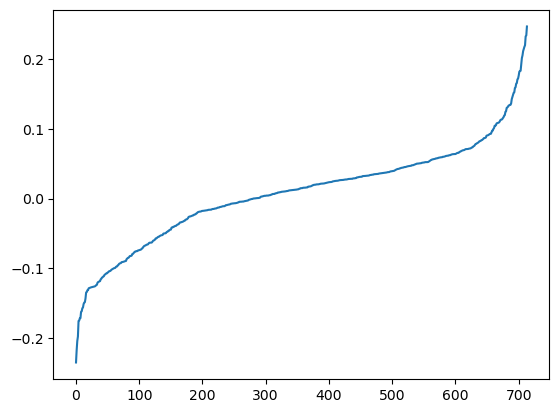

return without cost statistics
mean 0.003303767352020597
std 0.016531931322642694
sharpe 0.19984158460032103
double sharpe 1.663314491790431
max drawdown 0.2593515853146397
return with cost statistics
mean 0.002150335033713031
std 0.0165484556793854
sharpe 0.1299417344659978
double sharpe 1.0259573232103234
max drawdown 0.25928950094188224


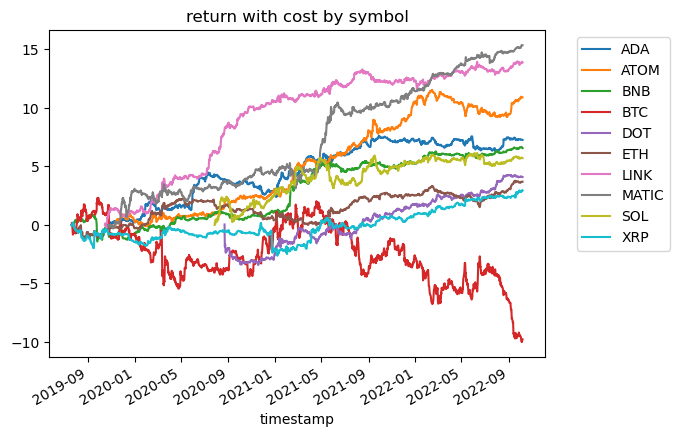

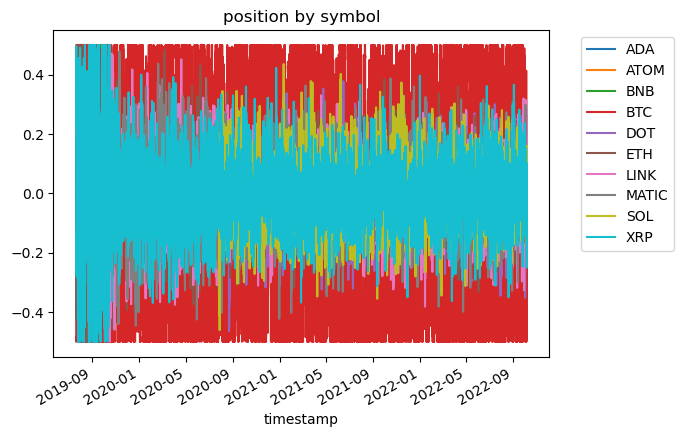

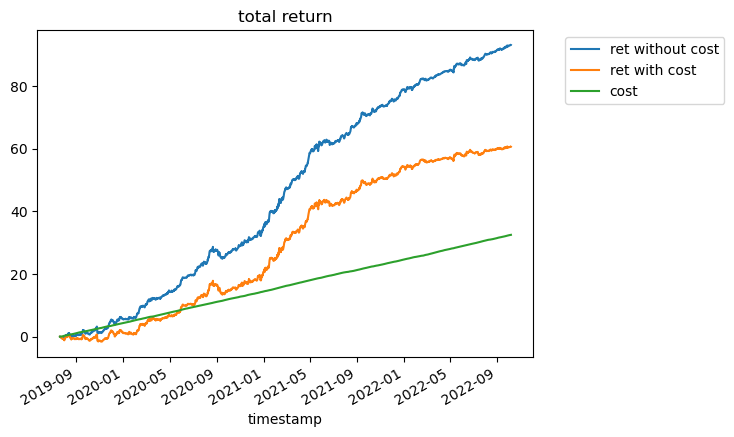

fit df.shape (225839, 730)
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[128, 128]
[128, 1]
[714, 128]
[

INFO:tensorflow:Assets written to: /tmp/tmp61ww8o9d/assets
2022-10-18 07:34:05.494236: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:05.494805: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:05.497367: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp61ww8o9d
2022-10-18 07:34:05.500733: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:05.501320: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp61ww8o9d
2022-10-18 07:34:05.507635: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:05.567285: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp61ww8o9d
2022-10-18 07:34:05.578902: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8a476fo8/assets


INFO:tensorflow:Assets written to: /tmp/tmp8a476fo8/assets
2022-10-18 07:34:06.753140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:06.753194: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:06.753331: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8a476fo8
2022-10-18 07:34:06.754631: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:06.754651: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8a476fo8
2022-10-18 07:34:06.758823: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:06.822121: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8a476fo8
2022-10-18 07:34:06.832594: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8nylyq8w/assets


INFO:tensorflow:Assets written to: /tmp/tmp8nylyq8w/assets
2022-10-18 07:34:07.928574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:07.928636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:07.928778: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8nylyq8w
2022-10-18 07:34:07.930097: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:07.930118: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8nylyq8w
2022-10-18 07:34:07.934376: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:07.992631: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8nylyq8w
2022-10-18 07:34:08.002948: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplmxcuu9l/assets


INFO:tensorflow:Assets written to: /tmp/tmplmxcuu9l/assets
2022-10-18 07:34:09.062051: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:09.062102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:09.062251: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplmxcuu9l
2022-10-18 07:34:09.063293: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:09.063311: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplmxcuu9l
2022-10-18 07:34:09.067034: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:09.109786: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplmxcuu9l
2022-10-18 07:34:09.119284: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpciog4jpq/assets


INFO:tensorflow:Assets written to: /tmp/tmpciog4jpq/assets
2022-10-18 07:34:10.130885: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:10.130935: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:10.131052: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpciog4jpq
2022-10-18 07:34:10.132231: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:10.132283: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpciog4jpq
2022-10-18 07:34:10.135831: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:10.201901: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpciog4jpq
2022-10-18 07:34:10.212269: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjdjw9i5e/assets


INFO:tensorflow:Assets written to: /tmp/tmpjdjw9i5e/assets
2022-10-18 07:34:11.230695: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:11.230743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:11.230859: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjdjw9i5e
2022-10-18 07:34:11.232034: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:11.232053: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjdjw9i5e
2022-10-18 07:34:11.235631: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:11.277532: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjdjw9i5e
2022-10-18 07:34:11.287049: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppu1_n390/assets


INFO:tensorflow:Assets written to: /tmp/tmppu1_n390/assets
2022-10-18 07:34:12.293087: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:12.293135: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:12.293277: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppu1_n390
2022-10-18 07:34:12.294507: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:12.294545: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppu1_n390
2022-10-18 07:34:12.299393: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:12.361445: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppu1_n390
2022-10-18 07:34:12.371840: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfu5makb9/assets


INFO:tensorflow:Assets written to: /tmp/tmpfu5makb9/assets
2022-10-18 07:34:13.399003: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:13.399059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:13.399252: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfu5makb9
2022-10-18 07:34:13.401242: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:13.401264: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfu5makb9
2022-10-18 07:34:13.409672: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:13.453664: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfu5makb9
2022-10-18 07:34:13.462486: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgbjls1ol/assets


INFO:tensorflow:Assets written to: /tmp/tmpgbjls1ol/assets
2022-10-18 07:34:14.479099: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:14.479147: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:14.479266: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgbjls1ol
2022-10-18 07:34:14.480468: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:14.480509: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgbjls1ol
2022-10-18 07:34:14.485123: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:14.537576: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgbjls1ol
2022-10-18 07:34:14.547978: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphvdww3rn/assets


INFO:tensorflow:Assets written to: /tmp/tmphvdww3rn/assets
2022-10-18 07:34:15.554213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:15.554267: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:15.554418: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphvdww3rn
2022-10-18 07:34:15.555546: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:15.555564: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphvdww3rn
2022-10-18 07:34:15.560504: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:15.603585: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphvdww3rn
2022-10-18 07:34:15.612092: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwqb6kxwh/assets


INFO:tensorflow:Assets written to: /tmp/tmpwqb6kxwh/assets
2022-10-18 07:34:16.668850: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:16.668901: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:16.669052: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwqb6kxwh
2022-10-18 07:34:16.670172: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:16.670190: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwqb6kxwh
2022-10-18 07:34:16.674977: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:16.729295: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwqb6kxwh
2022-10-18 07:34:16.739550: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuq1qnjmb/assets


INFO:tensorflow:Assets written to: /tmp/tmpuq1qnjmb/assets
2022-10-18 07:34:17.758182: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:17.758229: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:17.758368: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuq1qnjmb
2022-10-18 07:34:17.759480: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:17.759499: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuq1qnjmb
2022-10-18 07:34:17.764202: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:17.812646: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuq1qnjmb
2022-10-18 07:34:17.823384: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3bgfj1tk/assets


INFO:tensorflow:Assets written to: /tmp/tmp3bgfj1tk/assets
2022-10-18 07:34:18.856109: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:18.856159: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:18.856283: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3bgfj1tk
2022-10-18 07:34:18.857601: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:18.857620: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3bgfj1tk
2022-10-18 07:34:18.862197: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:18.907402: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3bgfj1tk
2022-10-18 07:34:18.916180: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp152vcbpy/assets


INFO:tensorflow:Assets written to: /tmp/tmp152vcbpy/assets
2022-10-18 07:34:19.940700: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:19.940749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:19.940905: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp152vcbpy
2022-10-18 07:34:19.942048: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:19.942066: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp152vcbpy
2022-10-18 07:34:19.946736: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:19.989591: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp152vcbpy
2022-10-18 07:34:19.999198: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy8fshvf1/assets


INFO:tensorflow:Assets written to: /tmp/tmpy8fshvf1/assets
2022-10-18 07:34:21.037648: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:21.037696: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:21.037813: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy8fshvf1
2022-10-18 07:34:21.038942: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:21.038960: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy8fshvf1
2022-10-18 07:34:21.043457: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:21.093961: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy8fshvf1
2022-10-18 07:34:21.104411: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmysdxkma/assets


INFO:tensorflow:Assets written to: /tmp/tmpmysdxkma/assets
2022-10-18 07:34:22.224878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:22.224933: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:22.225058: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmysdxkma
2022-10-18 07:34:22.226213: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:22.226231: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmysdxkma
2022-10-18 07:34:22.230829: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:22.282635: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmysdxkma
2022-10-18 07:34:22.292992: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxr_wzjya/assets


INFO:tensorflow:Assets written to: /tmp/tmpxr_wzjya/assets
2022-10-18 07:34:23.342377: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:23.342427: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:23.342545: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxr_wzjya
2022-10-18 07:34:23.343756: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:23.343776: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxr_wzjya
2022-10-18 07:34:23.348292: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:23.388204: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxr_wzjya
2022-10-18 07:34:23.399830: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa022x0m3/assets


INFO:tensorflow:Assets written to: /tmp/tmpa022x0m3/assets
2022-10-18 07:34:24.416744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:24.416811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:24.416981: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa022x0m3
2022-10-18 07:34:24.418660: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:24.418679: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa022x0m3
2022-10-18 07:34:24.423566: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:24.465075: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa022x0m3
2022-10-18 07:34:24.473687: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1li7mxy6/assets


INFO:tensorflow:Assets written to: /tmp/tmp1li7mxy6/assets
2022-10-18 07:34:25.484415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:25.484469: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:25.484592: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1li7mxy6
2022-10-18 07:34:25.485765: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:25.485784: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1li7mxy6
2022-10-18 07:34:25.490500: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:25.535205: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1li7mxy6
2022-10-18 07:34:25.543829: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp5hlzzyu/assets


INFO:tensorflow:Assets written to: /tmp/tmpp5hlzzyu/assets
2022-10-18 07:34:26.575672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:26.575734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:26.575877: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp5hlzzyu
2022-10-18 07:34:26.577285: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:26.577309: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp5hlzzyu
2022-10-18 07:34:26.582679: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:26.624419: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp5hlzzyu
2022-10-18 07:34:26.633550: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprku5iy63/assets


INFO:tensorflow:Assets written to: /tmp/tmprku5iy63/assets
2022-10-18 07:34:27.655204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:27.655259: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:27.655386: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprku5iy63
2022-10-18 07:34:27.656723: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:27.656742: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprku5iy63
2022-10-18 07:34:27.661701: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:27.702732: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprku5iy63
2022-10-18 07:34:27.711970: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp96te6e3r/assets


INFO:tensorflow:Assets written to: /tmp/tmp96te6e3r/assets
2022-10-18 07:34:28.726213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:28.726261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:28.726399: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp96te6e3r
2022-10-18 07:34:28.727527: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:28.727545: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp96te6e3r
2022-10-18 07:34:28.732187: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:28.770870: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp96te6e3r
2022-10-18 07:34:28.779931: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps8lou9qk/assets


INFO:tensorflow:Assets written to: /tmp/tmps8lou9qk/assets
2022-10-18 07:34:29.824352: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:29.824399: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:29.824562: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps8lou9qk
2022-10-18 07:34:29.825713: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:29.825731: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps8lou9qk
2022-10-18 07:34:29.830514: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:29.869248: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps8lou9qk
2022-10-18 07:34:29.878084: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgstlbudz/assets


INFO:tensorflow:Assets written to: /tmp/tmpgstlbudz/assets
2022-10-18 07:34:30.871411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:30.871459: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:30.871575: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgstlbudz
2022-10-18 07:34:30.872691: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:30.872709: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgstlbudz
2022-10-18 07:34:30.877605: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:30.916245: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgstlbudz
2022-10-18 07:34:30.926799: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpztx6l_cr/assets


INFO:tensorflow:Assets written to: /tmp/tmpztx6l_cr/assets
2022-10-18 07:34:31.961232: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:31.961280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:31.961421: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpztx6l_cr
2022-10-18 07:34:31.962546: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:31.962564: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpztx6l_cr
2022-10-18 07:34:31.967019: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:32.007394: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpztx6l_cr
2022-10-18 07:34:32.016390: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb7md51dd/assets


INFO:tensorflow:Assets written to: /tmp/tmpb7md51dd/assets
2022-10-18 07:34:33.004762: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:33.004816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:33.005130: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb7md51dd
2022-10-18 07:34:33.006671: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:33.006693: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb7md51dd
2022-10-18 07:34:33.012256: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:33.050951: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb7md51dd
2022-10-18 07:34:33.060756: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp59gfqv21/assets


INFO:tensorflow:Assets written to: /tmp/tmp59gfqv21/assets
2022-10-18 07:34:34.070720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:34.070785: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:34.070919: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp59gfqv21
2022-10-18 07:34:34.072371: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:34.072394: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp59gfqv21
2022-10-18 07:34:34.077189: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:34.116640: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp59gfqv21
2022-10-18 07:34:34.125556: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0gpndahx/assets


INFO:tensorflow:Assets written to: /tmp/tmp0gpndahx/assets
2022-10-18 07:34:38.799291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:38.799349: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:38.799529: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0gpndahx
2022-10-18 07:34:38.801856: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:38.801881: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0gpndahx
2022-10-18 07:34:38.812109: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:38.888110: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0gpndahx
2022-10-18 07:34:38.906628: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7wyyhznp/assets


INFO:tensorflow:Assets written to: /tmp/tmp7wyyhznp/assets
2022-10-18 07:34:40.067865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:40.067927: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:40.068076: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7wyyhznp
2022-10-18 07:34:40.069782: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:40.069808: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7wyyhznp
2022-10-18 07:34:40.076219: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:40.131928: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7wyyhznp
2022-10-18 07:34:40.143062: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqo_mybug/assets


INFO:tensorflow:Assets written to: /tmp/tmpqo_mybug/assets
2022-10-18 07:34:41.207250: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:41.207299: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:41.207448: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqo_mybug
2022-10-18 07:34:41.208666: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:41.208685: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqo_mybug
2022-10-18 07:34:41.213557: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:41.257258: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqo_mybug
2022-10-18 07:34:41.267635: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp972t0yto/assets


INFO:tensorflow:Assets written to: /tmp/tmp972t0yto/assets
2022-10-18 07:34:42.298098: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:42.298145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:42.298260: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp972t0yto
2022-10-18 07:34:42.299412: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:42.299430: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp972t0yto
2022-10-18 07:34:42.304090: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:42.347337: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp972t0yto
2022-10-18 07:34:42.357012: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkbe80ysi/assets


INFO:tensorflow:Assets written to: /tmp/tmpkbe80ysi/assets
2022-10-18 07:34:43.407491: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:43.407541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:43.407685: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkbe80ysi
2022-10-18 07:34:43.408827: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:43.408844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkbe80ysi
2022-10-18 07:34:43.413300: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:43.459464: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkbe80ysi
2022-10-18 07:34:43.468884: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpugj2vxkj/assets


INFO:tensorflow:Assets written to: /tmp/tmpugj2vxkj/assets
2022-10-18 07:34:44.514435: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:44.514580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:44.514786: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpugj2vxkj
2022-10-18 07:34:44.516084: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:44.516105: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpugj2vxkj
2022-10-18 07:34:44.520701: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:44.566704: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpugj2vxkj
2022-10-18 07:34:44.576256: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo05r3rmi/assets


INFO:tensorflow:Assets written to: /tmp/tmpo05r3rmi/assets
2022-10-18 07:34:45.588633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:45.588704: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:45.588824: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo05r3rmi
2022-10-18 07:34:45.589965: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:45.589984: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo05r3rmi
2022-10-18 07:34:45.593949: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:45.635432: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo05r3rmi
2022-10-18 07:34:45.644682: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprtevtrtl/assets


INFO:tensorflow:Assets written to: /tmp/tmprtevtrtl/assets
2022-10-18 07:34:46.666985: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:46.667037: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:46.667233: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprtevtrtl
2022-10-18 07:34:46.668358: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:46.668375: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprtevtrtl
2022-10-18 07:34:46.672303: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:46.723575: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprtevtrtl
2022-10-18 07:34:46.733082: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7z0b67ui/assets


INFO:tensorflow:Assets written to: /tmp/tmp7z0b67ui/assets
2022-10-18 07:34:47.751772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:47.751821: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:47.751941: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7z0b67ui
2022-10-18 07:34:47.753070: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:47.753089: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7z0b67ui
2022-10-18 07:34:47.757118: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:47.797707: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7z0b67ui
2022-10-18 07:34:47.806550: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnc44d1rb/assets


INFO:tensorflow:Assets written to: /tmp/tmpnc44d1rb/assets
2022-10-18 07:34:48.853267: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:48.853316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:48.853494: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnc44d1rb
2022-10-18 07:34:48.854758: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:48.854777: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnc44d1rb
2022-10-18 07:34:48.859043: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:48.905274: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnc44d1rb
2022-10-18 07:34:48.914619: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc5mxmig4/assets


INFO:tensorflow:Assets written to: /tmp/tmpc5mxmig4/assets
2022-10-18 07:34:49.919348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:49.919410: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:49.919553: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc5mxmig4
2022-10-18 07:34:49.920905: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:49.920928: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc5mxmig4
2022-10-18 07:34:49.925555: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:49.966806: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc5mxmig4
2022-10-18 07:34:49.978151: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf0wlg83y/assets


INFO:tensorflow:Assets written to: /tmp/tmpf0wlg83y/assets
2022-10-18 07:34:50.977332: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:50.977415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:50.977588: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf0wlg83y
2022-10-18 07:34:50.978668: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:50.978685: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf0wlg83y
2022-10-18 07:34:50.982790: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:51.022099: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf0wlg83y
2022-10-18 07:34:51.031105: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdnztfyjo/assets


INFO:tensorflow:Assets written to: /tmp/tmpdnztfyjo/assets
2022-10-18 07:34:52.143906: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:52.143968: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:52.144158: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdnztfyjo
2022-10-18 07:34:52.145527: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:52.145564: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdnztfyjo
2022-10-18 07:34:52.150126: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:52.197632: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdnztfyjo
2022-10-18 07:34:52.207579: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppmuw1fya/assets


INFO:tensorflow:Assets written to: /tmp/tmppmuw1fya/assets
2022-10-18 07:34:53.236476: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:53.236527: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:53.236677: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppmuw1fya
2022-10-18 07:34:53.237778: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:53.237797: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppmuw1fya
2022-10-18 07:34:53.241831: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:53.282668: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppmuw1fya
2022-10-18 07:34:53.294223: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpda5m9xk_/assets


INFO:tensorflow:Assets written to: /tmp/tmpda5m9xk_/assets
2022-10-18 07:34:54.325219: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:54.325265: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:54.325407: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpda5m9xk_
2022-10-18 07:34:54.326448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:54.326464: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpda5m9xk_
2022-10-18 07:34:54.330167: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:54.368530: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpda5m9xk_
2022-10-18 07:34:54.376909: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpoz3spcbj/assets


INFO:tensorflow:Assets written to: /tmp/tmpoz3spcbj/assets
2022-10-18 07:34:55.398657: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:55.398789: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:55.399085: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoz3spcbj
2022-10-18 07:34:55.400270: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:55.400287: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoz3spcbj
2022-10-18 07:34:55.404082: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:55.444644: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoz3spcbj
2022-10-18 07:34:55.453539: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4zjlj7v2/assets


INFO:tensorflow:Assets written to: /tmp/tmp4zjlj7v2/assets
2022-10-18 07:34:56.475191: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:56.475263: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:56.475599: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4zjlj7v2
2022-10-18 07:34:56.477886: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:56.477905: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4zjlj7v2
2022-10-18 07:34:56.482923: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:56.529231: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4zjlj7v2
2022-10-18 07:34:56.537752: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8jkl4tem/assets


INFO:tensorflow:Assets written to: /tmp/tmp8jkl4tem/assets
2022-10-18 07:34:57.553851: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:57.553899: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:57.554084: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8jkl4tem
2022-10-18 07:34:57.555259: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:57.555277: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8jkl4tem
2022-10-18 07:34:57.558987: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:57.600684: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8jkl4tem
2022-10-18 07:34:57.609465: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcg4pjntc/assets


INFO:tensorflow:Assets written to: /tmp/tmpcg4pjntc/assets
2022-10-18 07:34:58.637973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:58.638032: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:58.638173: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcg4pjntc
2022-10-18 07:34:58.639515: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:58.639535: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcg4pjntc
2022-10-18 07:34:58.643985: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:58.712191: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcg4pjntc
2022-10-18 07:34:58.723000: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3fogbki9/assets


INFO:tensorflow:Assets written to: /tmp/tmp3fogbki9/assets
2022-10-18 07:34:59.755075: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:34:59.755123: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:34:59.755241: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3fogbki9
2022-10-18 07:34:59.756430: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:34:59.756449: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3fogbki9
2022-10-18 07:34:59.760517: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:34:59.809904: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3fogbki9
2022-10-18 07:34:59.819717: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuh53pczx/assets


INFO:tensorflow:Assets written to: /tmp/tmpuh53pczx/assets
2022-10-18 07:35:00.833019: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:00.833066: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:00.833228: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuh53pczx
2022-10-18 07:35:00.834437: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:00.834457: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuh53pczx
2022-10-18 07:35:00.838409: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:00.896910: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuh53pczx
2022-10-18 07:35:00.907279: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpctyx2rh5/assets


INFO:tensorflow:Assets written to: /tmp/tmpctyx2rh5/assets
2022-10-18 07:35:01.911771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:01.911823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:01.911950: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpctyx2rh5
2022-10-18 07:35:01.913275: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:01.913295: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpctyx2rh5
2022-10-18 07:35:01.916880: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:01.955490: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpctyx2rh5
2022-10-18 07:35:01.964376: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpg9ug2a5f/assets


INFO:tensorflow:Assets written to: /tmp/tmpg9ug2a5f/assets
2022-10-18 07:35:02.963662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:02.963792: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:02.963910: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpg9ug2a5f
2022-10-18 07:35:02.965054: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:02.965073: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpg9ug2a5f
2022-10-18 07:35:02.968584: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:03.007123: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpg9ug2a5f
2022-10-18 07:35:03.015878: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb4zb5zmk/assets


INFO:tensorflow:Assets written to: /tmp/tmpb4zb5zmk/assets
2022-10-18 07:35:04.033886: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:04.033936: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:04.034088: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb4zb5zmk
2022-10-18 07:35:04.035241: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:04.035260: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb4zb5zmk
2022-10-18 07:35:04.038928: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:04.078040: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb4zb5zmk
2022-10-18 07:35:04.086925: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpryibmggq/assets


INFO:tensorflow:Assets written to: /tmp/tmpryibmggq/assets
2022-10-18 07:35:05.087564: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:05.087616: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:05.087738: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpryibmggq
2022-10-18 07:35:05.088830: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:05.088847: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpryibmggq
2022-10-18 07:35:05.092435: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:05.130156: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpryibmggq
2022-10-18 07:35:05.139515: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpaj3ftywz/assets


INFO:tensorflow:Assets written to: /tmp/tmpaj3ftywz/assets
2022-10-18 07:35:06.239068: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:06.239130: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:06.239260: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpaj3ftywz
2022-10-18 07:35:06.240379: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:06.240400: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpaj3ftywz
2022-10-18 07:35:06.244318: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:06.283931: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpaj3ftywz
2022-10-18 07:35:06.293050: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5tmdnzrq/assets


INFO:tensorflow:Assets written to: /tmp/tmp5tmdnzrq/assets
2022-10-18 07:35:10.235059: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:10.235129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:10.235309: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5tmdnzrq
2022-10-18 07:35:10.237996: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:10.238050: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5tmdnzrq
2022-10-18 07:35:10.248460: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:10.334342: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5tmdnzrq
2022-10-18 07:35:10.349621: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpskb1xlg0/assets


INFO:tensorflow:Assets written to: /tmp/tmpskb1xlg0/assets
2022-10-18 07:35:11.435404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:11.435454: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:11.435574: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpskb1xlg0
2022-10-18 07:35:11.436870: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:11.436891: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpskb1xlg0
2022-10-18 07:35:11.442557: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:11.494050: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpskb1xlg0
2022-10-18 07:35:11.509591: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps3pu8m49/assets


INFO:tensorflow:Assets written to: /tmp/tmps3pu8m49/assets
2022-10-18 07:35:12.786856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:12.786905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:12.787049: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps3pu8m49
2022-10-18 07:35:12.788377: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:12.788397: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps3pu8m49
2022-10-18 07:35:12.793551: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:12.843840: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps3pu8m49
2022-10-18 07:35:12.855657: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3sxw0_ra/assets


INFO:tensorflow:Assets written to: /tmp/tmp3sxw0_ra/assets
2022-10-18 07:35:13.895658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:13.895736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:13.895884: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3sxw0_ra
2022-10-18 07:35:13.897484: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:13.897508: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3sxw0_ra
2022-10-18 07:35:13.902716: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:13.965161: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3sxw0_ra
2022-10-18 07:35:13.976133: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpug1soje2/assets


INFO:tensorflow:Assets written to: /tmp/tmpug1soje2/assets
2022-10-18 07:35:15.014114: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:15.014166: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:15.014286: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpug1soje2
2022-10-18 07:35:15.015920: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:15.015970: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpug1soje2
2022-10-18 07:35:15.020494: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:15.071045: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpug1soje2
2022-10-18 07:35:15.080960: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp40ildy8r/assets


INFO:tensorflow:Assets written to: /tmp/tmp40ildy8r/assets
2022-10-18 07:35:16.111547: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:16.111595: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:16.111738: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp40ildy8r
2022-10-18 07:35:16.112891: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:16.112909: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp40ildy8r
2022-10-18 07:35:16.116978: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:16.157806: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp40ildy8r
2022-10-18 07:35:16.167352: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpick6svre/assets


INFO:tensorflow:Assets written to: /tmp/tmpick6svre/assets
2022-10-18 07:35:17.167790: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:17.167837: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:17.167953: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpick6svre
2022-10-18 07:35:17.169105: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:17.169124: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpick6svre
2022-10-18 07:35:17.173156: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:17.213974: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpick6svre
2022-10-18 07:35:17.223379: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpl_gchz4p/assets


INFO:tensorflow:Assets written to: /tmp/tmpl_gchz4p/assets
2022-10-18 07:35:18.228928: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:18.228978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:18.229115: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl_gchz4p
2022-10-18 07:35:18.230303: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:18.230322: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl_gchz4p
2022-10-18 07:35:18.234562: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:18.277874: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl_gchz4p
2022-10-18 07:35:18.289558: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsawn380d/assets


INFO:tensorflow:Assets written to: /tmp/tmpsawn380d/assets
2022-10-18 07:35:19.326923: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:19.326983: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:19.327152: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsawn380d
2022-10-18 07:35:19.328602: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:19.328625: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsawn380d
2022-10-18 07:35:19.333548: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:19.378043: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsawn380d
2022-10-18 07:35:19.387206: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2veo7jb2/assets


INFO:tensorflow:Assets written to: /tmp/tmp2veo7jb2/assets
2022-10-18 07:35:20.480486: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:20.480534: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:20.480649: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2veo7jb2
2022-10-18 07:35:20.481793: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:20.481813: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2veo7jb2
2022-10-18 07:35:20.485845: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:20.532682: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2veo7jb2
2022-10-18 07:35:20.543388: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1vzs2szy/assets


INFO:tensorflow:Assets written to: /tmp/tmp1vzs2szy/assets
2022-10-18 07:35:21.626324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:21.626383: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:21.626523: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1vzs2szy
2022-10-18 07:35:21.627962: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:21.627985: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1vzs2szy
2022-10-18 07:35:21.632698: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:21.675788: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1vzs2szy
2022-10-18 07:35:21.684772: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4vcynfnv/assets


INFO:tensorflow:Assets written to: /tmp/tmp4vcynfnv/assets
2022-10-18 07:35:22.717313: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:22.717368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:22.717492: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4vcynfnv
2022-10-18 07:35:22.718743: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:22.718764: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4vcynfnv
2022-10-18 07:35:22.723067: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:22.764620: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4vcynfnv
2022-10-18 07:35:22.774845: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3yurzyka/assets


INFO:tensorflow:Assets written to: /tmp/tmp3yurzyka/assets
2022-10-18 07:35:23.819555: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:23.819603: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:23.819747: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3yurzyka
2022-10-18 07:35:23.820869: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:23.820887: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3yurzyka
2022-10-18 07:35:23.824873: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:23.864834: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3yurzyka
2022-10-18 07:35:23.874310: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6xld718w/assets


INFO:tensorflow:Assets written to: /tmp/tmp6xld718w/assets
2022-10-18 07:35:24.872561: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:24.872607: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:24.872910: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6xld718w
2022-10-18 07:35:24.874566: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:24.874587: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6xld718w
2022-10-18 07:35:24.878828: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:24.923375: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6xld718w
2022-10-18 07:35:24.932500: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbc4qowvg/assets


INFO:tensorflow:Assets written to: /tmp/tmpbc4qowvg/assets
2022-10-18 07:35:25.930509: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:25.930562: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:25.930690: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbc4qowvg
2022-10-18 07:35:25.931941: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:25.931962: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbc4qowvg
2022-10-18 07:35:25.936378: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:25.977580: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbc4qowvg
2022-10-18 07:35:25.988058: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphwe141l6/assets


INFO:tensorflow:Assets written to: /tmp/tmphwe141l6/assets
2022-10-18 07:35:27.020827: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:27.020868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:27.021114: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphwe141l6
2022-10-18 07:35:27.022429: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:27.022449: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphwe141l6
2022-10-18 07:35:27.026705: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:27.070357: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphwe141l6
2022-10-18 07:35:27.079971: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbwjvtnig/assets


INFO:tensorflow:Assets written to: /tmp/tmpbwjvtnig/assets
2022-10-18 07:35:28.098415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:28.098464: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:28.098586: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbwjvtnig
2022-10-18 07:35:28.099992: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:28.100013: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbwjvtnig
2022-10-18 07:35:28.103809: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:28.145667: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbwjvtnig
2022-10-18 07:35:28.154080: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb5dc1ihw/assets


INFO:tensorflow:Assets written to: /tmp/tmpb5dc1ihw/assets
2022-10-18 07:35:29.173446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:29.173495: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:29.173614: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb5dc1ihw
2022-10-18 07:35:29.174776: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:29.174796: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb5dc1ihw
2022-10-18 07:35:29.178837: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:29.217689: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb5dc1ihw
2022-10-18 07:35:29.226502: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppgsxhgng/assets


INFO:tensorflow:Assets written to: /tmp/tmppgsxhgng/assets
2022-10-18 07:35:30.324191: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:30.324241: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:30.324359: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppgsxhgng
2022-10-18 07:35:30.325502: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:30.325521: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppgsxhgng
2022-10-18 07:35:30.329275: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:30.369478: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppgsxhgng
2022-10-18 07:35:30.379352: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfci2j55h/assets


INFO:tensorflow:Assets written to: /tmp/tmpfci2j55h/assets
2022-10-18 07:35:33.359901: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:33.359966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:33.360143: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfci2j55h
2022-10-18 07:35:33.363015: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:33.363040: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfci2j55h
2022-10-18 07:35:33.377587: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:33.467979: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfci2j55h
2022-10-18 07:35:33.489908: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp94dvlqsg/assets


INFO:tensorflow:Assets written to: /tmp/tmp94dvlqsg/assets
2022-10-18 07:35:34.765919: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:34.765995: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:34.766142: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp94dvlqsg
2022-10-18 07:35:34.768042: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:34.768068: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp94dvlqsg
2022-10-18 07:35:34.777325: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:34.837864: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp94dvlqsg
2022-10-18 07:35:34.850981: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiyzxzg1u/assets


INFO:tensorflow:Assets written to: /tmp/tmpiyzxzg1u/assets
2022-10-18 07:35:35.946414: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:35.946480: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:35.946631: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiyzxzg1u
2022-10-18 07:35:35.948656: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:35.948683: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiyzxzg1u
2022-10-18 07:35:35.955502: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:36.008612: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiyzxzg1u
2022-10-18 07:35:36.020542: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkin1rnl9/assets


INFO:tensorflow:Assets written to: /tmp/tmpkin1rnl9/assets
2022-10-18 07:35:37.074393: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:37.074498: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:37.074654: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkin1rnl9
2022-10-18 07:35:37.076300: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:37.076324: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkin1rnl9
2022-10-18 07:35:37.082310: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:37.136318: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkin1rnl9
2022-10-18 07:35:37.148146: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuy8ryivf/assets


INFO:tensorflow:Assets written to: /tmp/tmpuy8ryivf/assets
2022-10-18 07:35:38.259006: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:38.259074: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:38.259198: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuy8ryivf
2022-10-18 07:35:38.260584: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:38.260605: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuy8ryivf
2022-10-18 07:35:38.265690: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:38.318099: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuy8ryivf
2022-10-18 07:35:38.328396: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuakhgt4_/assets


INFO:tensorflow:Assets written to: /tmp/tmpuakhgt4_/assets
2022-10-18 07:35:39.373142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:39.373195: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:39.373313: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuakhgt4_
2022-10-18 07:35:39.374741: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:39.374763: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuakhgt4_
2022-10-18 07:35:39.379620: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:39.430220: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuakhgt4_
2022-10-18 07:35:39.440186: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp20ahf715/assets


INFO:tensorflow:Assets written to: /tmp/tmp20ahf715/assets
2022-10-18 07:35:40.478306: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:40.478370: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:40.478527: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp20ahf715
2022-10-18 07:35:40.479928: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:40.479947: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp20ahf715
2022-10-18 07:35:40.484556: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:40.528149: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp20ahf715
2022-10-18 07:35:40.537850: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpliygvu2k/assets


INFO:tensorflow:Assets written to: /tmp/tmpliygvu2k/assets
2022-10-18 07:35:41.560456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-18 07:35:41.560510: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-18 07:35:41.560632: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpliygvu2k
2022-10-18 07:35:41.561956: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-18 07:35:41.561978: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpliygvu2k
2022-10-18 07:35:41.567364: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-18 07:35:41.614278: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpliygvu2k
2022-10-18 07:35:41.623463: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [16]:
print(tf.keras.backend.floatx())

df = pd.read_pickle('/tmp/df_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon96_price_type_none.pkl')
# df = df.iloc[-10000:]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
# sol_timestamps = df.loc[df.index.get_level_values('symbol') == 'SOL'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]
# df = df.loc[df.index.get_level_values('timestamp').isin(sol_timestamps)]

model = ExampleModelRank(10)

# # cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221007_btc_one_nn.xz', 'wb') as f:
    f.write(data)

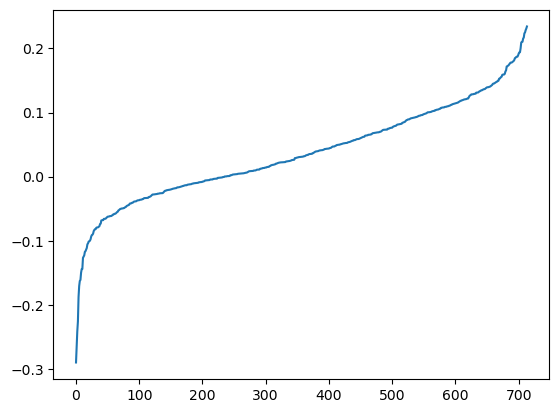

timestamp                  symbol
2022-08-09 04:00:00+00:00  ADA       0.058508
                           ATOM      0.059635
                           BNB       0.054025
                           BTC      -0.500000
                           DOT       0.056651
                                       ...   
2022-10-08 04:00:00+00:00  ETH      -0.110532
                           LINK      0.043604
                           MATIC     0.031349
                           SOL       0.047709
                           XRP       0.007023
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


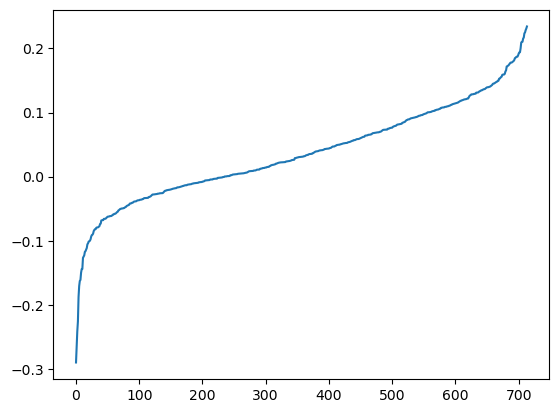

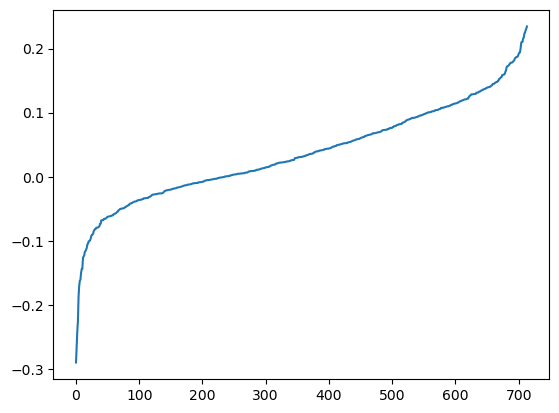

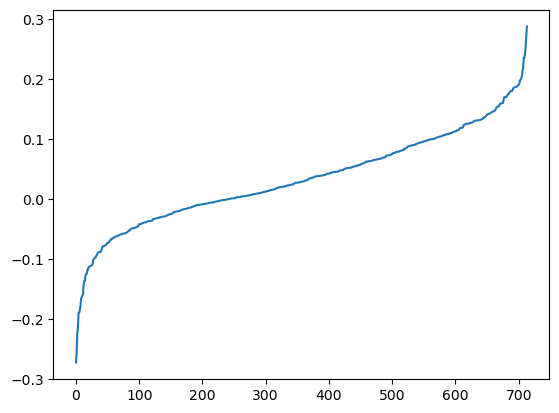

position1  position2  position3
timestamp                 symbol                                 
2022-08-09 05:00:00+00:00 ADA      0.032460   0.032460   0.049488
                          ATOM     0.114473   0.114473   0.057518
                          BNB     -0.075502  -0.075502   0.049545
                          BTC      0.297484   0.297484  -0.500000
                          DOT     -0.071888  -0.071888   0.063621
...                                     ...        ...        ...
2022-10-08 03:00:00+00:00 ETH     -0.096005  -0.096005  -0.097881
                          LINK     0.022304   0.022304   0.022740
                          MATIC    0.066317   0.066317   0.067614
                          SOL      0.030028   0.030028   0.028670
                          XRP      0.029760   0.029760   0.030612

[14390 rows x 3 columns]

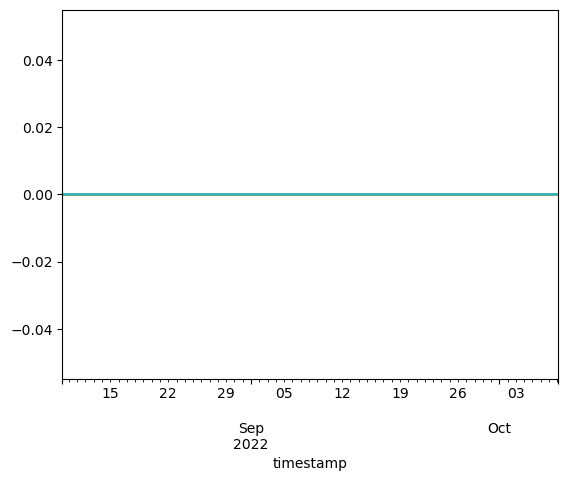

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


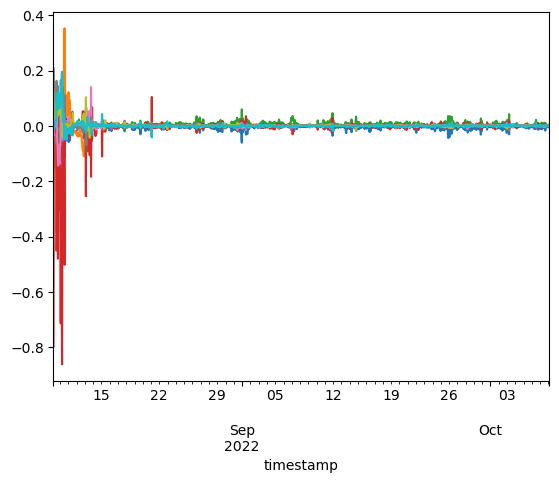

In [18]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/20221007_btc_one_nn.xz')
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()

In [ ]:
# https://arxiv.org/pdf/1902.06853.pdf

def eoc_v(f, sigma_w=1.0):
    def v(x):
        n = 10000
        z = np.random.normal(0, 1, n)
        return sigma_w ** 2 * np.mean(f(x ** 0.5 * z) ** 2)
    return v

def eoc_sigma_w(f, f_deriva, sigma_b=0.0):
    f_v = eoc_v(f)
    f_deriva_v = eoc_v(f_deriva)
    q = 0
    for i in range(100):
        q = sigma_b ** 2 + f_v(q) / f_deriva_v(q)
    return 1.0 / f_deriva_v(q) ** 0.5

# def gelu(x):
    
# def gelu_deriva(x):
    
    